<a href="https://colab.research.google.com/github/plaban1981/NLP/blob/master/support_tickets_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/karolzak/support-tickets-classification/blob/master/train_model.ipynb

https://realpython.com/python-keras-text-classification/

https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a

In [1]:
!wget "https://privdatastorage.blob.core.windows.net/github/support-tickets-classification/datasets/all_tickets.csv" 

--2019-07-26 06:26:07--  https://privdatastorage.blob.core.windows.net/github/support-tickets-classification/datasets/all_tickets.csv
Resolving privdatastorage.blob.core.windows.net (privdatastorage.blob.core.windows.net)... 52.239.140.10
Connecting to privdatastorage.blob.core.windows.net (privdatastorage.blob.core.windows.net)|52.239.140.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14982172 (14M) [application/vnd.ms-excel]
Saving to: ‘all_tickets.csv’

all_tickets.csv     100%[===================>]  14.29M  29.2MB/s    in 0.5s    

2019-07-26 06:26:13 (29.2 MB/s) - ‘all_tickets.csv’ saved [14982172/14982172]



In [0]:
import pandas as pd
dfTickets = pd.read_csv('all_tickets.csv')

In [3]:
dfTickets.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [4]:
dfTickets.shape

(48549, 9)

In [5]:
dfTickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48549 entries, 0 to 48548
Data columns (total 9 columns):
title               47837 non-null object
body                48549 non-null object
ticket_type         48549 non-null int64
category            48549 non-null int64
sub_category1       48549 non-null int64
sub_category2       48549 non-null int64
business_service    48549 non-null int64
urgency             48549 non-null int64
impact              48549 non-null int64
dtypes: int64(7), object(2)
memory usage: 3.3+ MB


# Import Libraries

In [0]:
import sys
import os
import nltk
import numpy as np
import pandas as pd
import pickle
import re
import string
from tqdm import tqdm #progress bar
from bs4 import BeautifulSoup
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
%matplotlib inline

## Checking null values

In [8]:
dfTickets.isnull().sum()[dfTickets.isnull().sum() > 0]

title    712
dtype: int64

In [0]:
# used to determine number of samples required for each class.Classes with less than that will be excluded from the dataset. default value is 1 
min_data_per_class = 1

# Removing rows related to classes represented by low amount of data

In [10]:
print("Shape of dataset before removing classes with less then " + str(min_data_per_class) + " rows: "+str(dfTickets.shape))


Shape of dataset before removing classes with less then 1 rows: (48549, 9)


In [11]:
print("Number of classes before removing classes with less then " + str(min_data_per_class) + " rows: "+str(len(np.unique(dfTickets['ticket_type']))))

Number of classes before removing classes with less then 1 rows: 2


## Distinct Labels

In [12]:
dfTickets['ticket_type'].value_counts()

1    34621
0    13928
Name: ticket_type, dtype: int64

## Text Preprocessing /Cleaning 

In [0]:
# convert contracted words to normal words
def decontracted(phrase):
  phrase = re.sub(r"won\'t","will not",phrase)
  phrase = re.sub(r"can\'t","cannot",phrase)
  phrase = re.sub(r"n\'t","not",phrase)
  phrase = re.sub(r"\'re","are",phrase)
  phrase = re.sub(r"\'d","would",phrase)
  phrase = re.sub(r"\'s","is",phrase)
  phrase = re.sub(r"\'ll","will",phrase)
  phrase = re.sub(r"\'t","not",phrase)
  phrase = re.sub(r"\'ve","have",phrase)
  phrase = re.sub(r"\'m","am",phrase)
  return phrase

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stopwords = set(stopwords.words('english'))

In [24]:
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [31]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:

ps =  nltk.stem.SnowballStemmer('english')

In [43]:
tokens = nltk.tokenize.word_tokenize("sita is going to village")
stemmed_tokens = []
for token in tokens:
  stemmed_tokens.append(ps.stem(token))
sentence = ' '.join(stemmed_tokens)
sentence

'sita is go to villag'

In [0]:
preprocessed_text = []

In [0]:
texts = dfTickets['body']

In [69]:
for sentence in tqdm(texts.values):
  #remove urls if any
  sentence = re.sub("http\S+"," ",sentence)
  #remove html tags
  sentence = BeautifulSoup(sentence,'lxml').get_text()
  #remove decontracted words
  sentence = decontracted(sentence)
  #remove words with number
  sentence = re.sub("\S*\d\S*"," ",sentence)
  #remove special characters
  sentence = re.sub("[^A-Za-z0-9]+"," ",sentence)
  #remove stopwords
  sentence = ' '.join([e.lower() for e in sentence.split() if e not in stopwords])
  #remove short words
  sentence = ' '.join([e for e in sentence.split() if len(e) > 2])
  #normalize text
  tokens = nltk.tokenize.word_tokenize(sentence)
  stemmed_tokens = []
  for token in tokens:
    stemmed_tokens.append(ps.stem(token))
  sentence = ' '.join(stemmed_tokens) 
  preprocessed_text.append(sentence)



  0%|          | 0/48549 [00:00<?, ?it/s]

  0%|          | 80/48549 [00:00<01:05, 742.07it/s]

  0%|          | 160/48549 [00:00<01:03, 757.18it/s]

  0%|          | 224/48549 [00:00<01:07, 715.45it/s]

  1%|          | 310/48549 [00:00<01:04, 752.88it/s]

  1%|          | 391/48549 [00:00<01:02, 767.02it/s]

  1%|          | 467/48549 [00:00<01:03, 761.81it/s]

  1%|          | 547/48549 [00:00<01:02, 772.70it/s]

  1%|▏         | 625/48549 [00:00<01:02, 771.79it/s]

  1%|▏         | 715/48549 [00:00<00:59, 800.71it/s]

  2%|▏         | 793/48549 [00:01<01:03, 751.12it/s]

  2%|▏         | 876/48549 [00:01<01:01, 771.63it/s]

  2%|▏         | 960/48549 [00:01<01:00, 790.68it/s]

  2%|▏         | 1050/48549 [00:01<00:59, 802.14it/s]

  2%|▏         | 1131/48549 [00:01<01:03, 742.10it/s]

  2%|▏         | 1206/48549 [00:01<01:03, 740.98it/s]

  3%|▎         | 1302/48549 [00:01<00:59, 794.66it/s]

  3%|▎         | 1383/48549 [00:01<01:02, 760.50it/s]

  3%|▎         | 1461/48549 [00:0

In [70]:
len(preprocessed_text)

48549

In [71]:
preprocessed_text[0]

'sinc recruit lead permiss approv requisit make pleas make thank recruit'

In [0]:
dfTickets['Preprocessed_Text'] = preprocessed_text


In [73]:
dfTickets[['body','Preprocessed_Text','ticket_type']].head()

,body,Preprocessed_Text,ticket_type
0,hi since recruiter lead permission approve req...,sinc recruit lead permiss approv requisit make...,1
1,icon dear please setup icon per icon engineers...,icon dear pleas setup icon per icon engin plea...,1
2,work experience user hi work experience studen...,work experi user work experi student come next...,1
3,requesting meeting hi please help follow equip...,request meet pleas help follow equip cabl cord...,1
4,re expire days hi ask help update passwords co...,expir day ask help updat password colleagu tha...,1


## Identify the Predictors and Labels

In [0]:
X = dfTickets['Preprocessed_Text']
Y = dfTickets['ticket_type']

## Test Train Split data

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=1)

In [76]:
X_train.head()

4208     colleagu good morn pleas colleagu pleas add th...
10155    wednesday leaver form leav date locat hello le...
30748    leader hello pleas add also pleas chang owner ...
7251     help hello group enrol pleas find thank lead t...
26310    novemb hello pleas employe updat serbian entit...
Name: Preprocessed_Text, dtype: object

In [77]:
X_test.head()

832      purchas dear purchas pleas log alloc pleas log...
25705    thursday decemb replac regular dear ask replac...
22008    friday februari assist starter test disciplin ...
27630                                              encrypt
28505    tuesday octob add colleagu pleas hello told as...
Name: Preprocessed_Text, dtype: object

## Generate Features from text

In [78]:
vectorizer = CountVectorizer(min_df=1, lowercase=False)
X_train_counts = vectorizer.fit_transform(X_train)
X_train_counts.shape

(38839, 6379)

In [79]:
X_test_counts = vectorizer.fit_transform(X_test)
X_test_counts.shape

(9710, 4462)

## Feature Extraction using TFIDF

In [80]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(38839, 6379)

In [81]:
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
X_test_tfidf.shape

(9710, 4462)

## Using pipeline to preprocess data and train classifier

##  Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:


The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.

We will be using the 'text_clf' going forward.

In [0]:
text_clf = Pipeline([
        ('vect', vectorizer),
        ('tfidf', tfidf_transformer),
        ('clf', MultinomialNB(fit_prior=True))])

In [0]:
 text_clf = text_clf.fit(X_train,y_train)

## Use GridSearchCV to search for best set of parameters

In [0]:
# NB parameters
parameters = {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        'clf__alpha': (1e-2, 1e-3)
    }

 ## Next, we create an instance of the grid search by passing the classifier, parameters and n_jobs=-1 which tells to use multiple cores from user machine.

In [88]:
grid = GridSearchCV(text_clf,parameters,n_jobs=-1)
grid.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=False,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                      

## Best Parameters selected via Grid Search

In [90]:
grid.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}

##Best Scores

In [92]:
grid.best_score_

0.9676356239861994

## Evaluate the model

In [0]:
predicted = text_clf.predict(X_test)


## Accuracy of the predictions without using best parmeters obtained from grid search 

In [103]:
from sklearn.metrics import accuracy_score
print("Accuracy Score of the model {}%".format(accuracy_score(y_test,predicted)*100))

Accuracy Score of the model 95.5406797116375%


## Evaluate the model based on the best parameters fro grid search

In [0]:
predicted_grid = grid.predict(X_test)

## Accuracy of the predictions using best parmeters obtained from grid 

In [102]:
print("Accuracy Score of the model {}%".format(accuracy_score(y_test,predicted_grid)*100))

Accuracy Score of the model 96.4572605561277%


## Confusion Matrix

In [100]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,predicted))

[[2482  265]
 [ 168 6795]]


## Confusion Matrix - Grid Search

In [101]:
print(confusion_matrix(y_test,predicted_grid))

[[2578  169]
 [ 175 6788]]


## Plot Confusion Matrix - without grid search

Text(0.5, 15.0, 'predicted label')

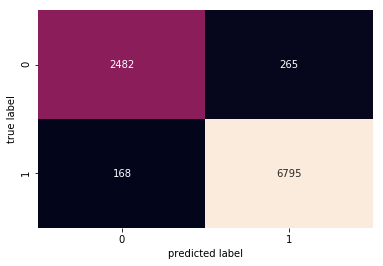

In [112]:
import seaborn as sns
mat1 = confusion_matrix(y_test,predicted)
sns.heatmap(mat1,annot=True,fmt='d', cbar=False)
plt.ylabel('true label')
plt.xlabel('predicted label')

##Plot Confusion Matrix - with grid search

Text(0.5, 15.0, 'Predicted label')

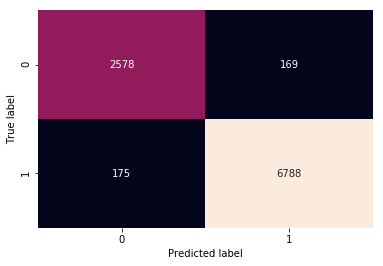

In [119]:
mat2 = confusion_matrix(y_test,predicted_grid)
sns.heatmap(mat2,annot=True,fmt='d',cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [116]:
!pip install scikit-plot

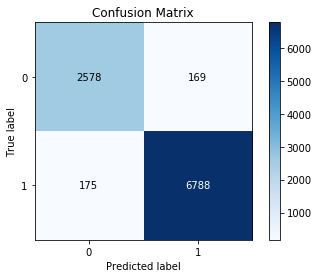

In [118]:
import scikitplot
scikitplot.metrics.plot_confusion_matrix(y_test,predicted_grid)

In [124]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_grid))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2747
           1       0.98      0.97      0.98      6963

    accuracy                           0.96      9710
   macro avg       0.96      0.96      0.96      9710
weighted avg       0.96      0.96      0.96      9710



In [0]:
df_pred = pd.DataFrame({'Test_body':X_test,'Actual_ticket_type':y_test,'Predicted_ticket_type':predicted_grid})

In [121]:
df_pred.head(10)

,Test_body,Actual_ticket_type,Predicted_ticket_type
832,purchas dear purchas pleas log alloc pleas log...,1,1
25705,thursday decemb replac regular dear ask replac...,1,1
22008,friday februari assist starter test disciplin ...,1,1
27630,encrypt,1,0
28505,tuesday octob add colleagu pleas hello told as...,1,1
36494,one issu hello tri access one download coupl p...,0,0
32744,wednesday pleas make code task thank let quest...,1,1
29184,octob test fix wire test octob readi help make...,1,1
4974,autom train hello novemb autom train novemb so...,1,1
15601,want boat march understand boat context propos...,1,1
